<a href="https://colab.research.google.com/github/AbdoAlkayal/Machine_Learning/blob/main/BrainTumorClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import models, layers, losses, optimizers
import pandas as pd
import zipfile
import random
from PIL import Image
import shutil
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
import time
from sklearn.svm import SVC, LinearSVC
from sklearn.cluster import DBSCAN


In [ ]:
from google.colab import files
uploaded = files.upload()






Saving Dataset.zip to Dataset.zip


In [ ]:

# Unzip the file
with zipfile.ZipFile('Dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('Dataset')

# Check contents
os.listdir('Dataset')


['Dataset']

In [ ]:

for root, dirs, files in os.walk('Dataset'):
    for file in files:
        print(os.path.join(root, file))


Dataset/Dataset/Brain Tumor Data Set/Grayscale_Brain_Healthy/Not Cancer  (2041).jpg
Dataset/Dataset/Brain Tumor Data Set/Grayscale_Brain_Healthy/Not Cancer  (37).jpg
Dataset/Dataset/Brain Tumor Data Set/Grayscale_Brain_Healthy/Not Cancer  (13).jpg
Dataset/Dataset/Brain Tumor Data Set/Grayscale_Brain_Healthy/Not Cancer  (14).jpg
Dataset/Dataset/Brain Tumor Data Set/Grayscale_Brain_Healthy/Not Cancer  (1887).jpg
Dataset/Dataset/Brain Tumor Data Set/Grayscale_Brain_Healthy/Not Cancer  (1824).jpg
Dataset/Dataset/Brain Tumor Data Set/Grayscale_Brain_Healthy/Not Cancer  (1555).jpg
Dataset/Dataset/Brain Tumor Data Set/Grayscale_Brain_Healthy/Not Cancer  (1235).jpg
Dataset/Dataset/Brain Tumor Data Set/Grayscale_Brain_Healthy/Not Cancer  (68).jpg
Dataset/Dataset/Brain Tumor Data Set/Grayscale_Brain_Healthy/Not Cancer  (299).jpg
Dataset/Dataset/Brain Tumor Data Set/Grayscale_Brain_Healthy/Not Cancer  (936).jpg
Dataset/Dataset/Brain Tumor Data Set/Grayscale_Brain_Healthy/Not Cancer  (1947).jpg
Da

In [ ]:

dataset_path = 'Dataset/Dataset/Brain Tumor Data Set'

batch_size = 32
img_height = 224
img_width = 224

train_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split=0.3,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split=0.3,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)


Found 4514 files belonging to 2 classes.
Using 3160 files for training.
Found 4514 files belonging to 2 classes.
Using 1354 files for validation.


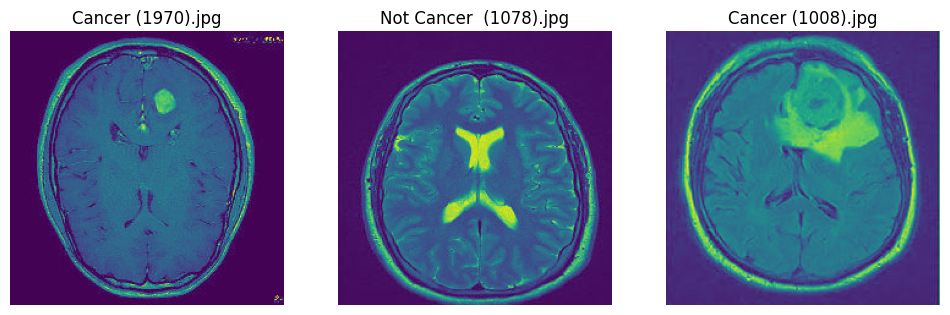

In [ ]:

# Path to your unzipped dataset folder (adjust if needed)
dataset_path = 'Dataset'

# Get all image file paths (assuming common image extensions)
image_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.gif']

all_images = []
for root, dirs, files in os.walk(dataset_path):
    for file in files:
        if any(file.lower().endswith(ext) for ext in image_extensions):
            all_images.append(os.path.join(root, file))

# Pick 3 random images
random_images = random.sample(all_images, 3)

# Plot the images
plt.figure(figsize=(12, 4))
for i, img_path in enumerate(random_images):
    img = Image.open(img_path)
    plt.subplot(1, 3, i + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(os.path.basename(img_path))
plt.show()


In [ ]:

from sklearn.decomposition import PCA
# Assuming train_ds is your tf.data.Dataset for training
# Extract images and flatten them into vectors

def dataset_to_numpy(ds):
    images = []
    labels = []
    for batch, label_batch in ds:
        images.append(batch.numpy())
        labels.append(label_batch.numpy())
    images = np.vstack(images)
    labels = np.hstack(labels)
    return images, labels

# Get numpy arrays from train_ds (images shape: (batch, height, width, channels))
train_images, train_labels = dataset_to_numpy(train_ds)

# Flatten images to vectors ( 224x224x3 = 150528 features)
n_samples = train_images.shape[0]
print(n_samples)
flat_images = train_images.reshape(n_samples, -1)  # feature extracion (converts 2d or 3d image into 1d vector)
print(flat_images)

print(f"Before PCA, feature shape: {flat_images.shape}")

# Apply PCA to reduce dimensionality
n_components = 100 # 100 eigen values (princpal components)
pca = PCA(n_components=n_components) # dimensionality reduction
reduced_features = pca.fit_transform(flat_images)
print(reduced_features)

print(f"After PCA, feature shape: {reduced_features.shape}")


3160
[[245. 245. 245. ... 234. 234. 234.]
 [  6.   6.   6. ...   7.   7.   7.]
 [ 67.  67.  67. ...  62.  62.  62.]
 ...
 [  0.   0.   0. ...  14.  14.  14.]
 [  2.   2.   2. ...   6.   6.   6.]
 [  4.   4.   4. ...   0.   0.   0.]]
Before PCA, feature shape: (3160, 150528)
[[ 1.0698786e+04 -5.6202900e+03 -9.5016779e+02 ...  4.2320834e+02
  -3.7162741e+02 -1.3658788e+00]
 [ 5.6540439e+03  6.2277402e+03  4.0235349e+02 ... -5.3719977e+02
  -8.3301337e+02  4.6475259e+02]
 [ 4.2274570e+03 -1.0057277e+04  1.7653839e+03 ...  8.6674896e+02
   2.9731244e+02  4.7768777e+02]
 ...
 [-5.9169316e+03  4.1055308e+03 -3.6622390e+03 ...  1.9483101e+02
   1.6337903e+02  9.9232658e+01]
 [ 1.3131168e+04  8.6387822e+03  6.0095552e+03 ...  1.9460088e+02
  -6.4734003e+02 -7.8426825e+02]
 [ 3.7380081e+03  2.6271089e+03 -4.5715410e+03 ...  1.7533899e+02
  -8.7046509e+02 -2.3530076e+03]]
After PCA, feature shape: (3160, 100)


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    reduced_features, train_labels, test_size=0.3, random_state=42, stratify=train_labels
)
# Full PCA-based dataset
X_train_full = X_train      # from train_test_split of full PCA data
y_train_full = y_train


In [ ]:
def evaluate_model(name, model, X_train, y_train, X_test, y_test):
    start_time = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start_time

    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)

    print(f"{name} -> Training time: {train_time:.2f}s, Accuracy: {acc:.4f}")
    return train_time, acc, y_pred, model

In [ ]:
def run_all_models(X_train, y_train, X_test, y_test, label=""):
    print(f"\n=== Evaluating on {label} Data ===\n")

    # 1. KNN
    knn_times = {}
    for k in [1, 3, 5, 7]:
        knn = KNeighborsClassifier(n_neighbors=k)
        t, acc, _, _ = evaluate_model(f"KNN (k={k})", knn, X_train, y_train, X_test, y_test)
        knn_times[k] = t

    # 2. Decision Tree
    dt = DecisionTreeClassifier(random_state=42)
    dt_time, dt_acc, dt_pred, _ = evaluate_model("Decision Tree", dt, X_train, y_train, X_test, y_test)
    print("\nClassification Report (DT):\n", classification_report(y_test, dt_pred))

    # 3. SVM (Linear)
    #svm = SVC(kernel='linear')
    svm = LinearSVC(dual=False, max_iter=10000)
    svm_time, svm_acc, svm_pred, _ = evaluate_model("SVM (LinearSVC)", svm, X_train, y_train, X_test, y_test)
    print("\nClassification Report (SVM):\n", classification_report(y_test, svm_pred))
    #print(f"Number of Support Vectors: {sum(svm.n_support_)}")  # Total across all classes

    return knn_times, dt_time, svm_time



In [ ]:
#  FULL PCA-REDUCED set
print("Running on full PCA-reduced dataset (100 eigenvectors)...")
knn_full, dt_full, svm_full = run_all_models(X_train_full, y_train_full, X_test, y_test, label="FULL PCA")

Running on full PCA-reduced dataset (100 eigenvectors)...

=== Evaluating on FULL PCA Data ===

KNN (k=1) -> Training time: 0.00s, Accuracy: 0.9209
KNN (k=3) -> Training time: 0.00s, Accuracy: 0.8861
KNN (k=5) -> Training time: 0.00s, Accuracy: 0.8586
KNN (k=7) -> Training time: 0.00s, Accuracy: 0.8281
Decision Tree -> Training time: 0.32s, Accuracy: 0.8544

Classification Report (DT):
               precision    recall  f1-score   support

           0       0.83      0.86      0.85       438
           1       0.88      0.85      0.86       510

    accuracy                           0.85       948
   macro avg       0.85      0.86      0.85       948
weighted avg       0.86      0.85      0.85       948

SVM (LinearSVC) -> Training time: 0.45s, Accuracy: 0.7395

Classification Report (SVM):
               precision    recall  f1-score   support

           0       0.73      0.68      0.71       438
           1       0.74      0.79      0.76       510

    accuracy                  

In [ ]:
from sklearn.cluster import DBSCAN
import numpy as np

# Store reduced samples as lists initially
reduced_X = []
reduced_y = []

# Loop through each class label
unique_labels = np.unique(y_train)

for label in unique_labels:
    print(f"\nProcessing class {label}...")

    # Extract only samples of this class
    class_X = X_train[y_train == label]
    class_y = y_train[y_train == label]

    # Apply DBSCAN (tune eps and min_samples as needed)
    dbscan = DBSCAN(eps=5.0, min_samples=3)
    dbscan.fit(class_X)

    # Keep all samples that are not labeled as noise (-1)
    mask = dbscan.labels_ != -1

    kept_X = class_X[mask]
    kept_y = class_y[mask]

    print(f"  Total samples in class: {len(class_X)}")
    print(f"  Samples kept (core + border): {len(kept_X)}")

    reduced_X.append(kept_X)
    reduced_y.append(kept_y)

# Concatenate after the loop
if reduced_X and reduced_y:
    reduced_X = np.vstack(reduced_X)
    reduced_y = np.hstack(reduced_y)
    print(f"\nFinal reduced dataset size: {reduced_X.shape}")
else:
    print("Reduced dataset is empty.")



Processing class 0...
  Total samples in class: 1023
  Samples kept (core + border): 57

Processing class 1...
  Total samples in class: 1189
  Samples kept (core + border): 18

Final reduced dataset size: (75, 100)


In [ ]:
# Reduced dataset (from DBSCAN border objects)
X_train_reduced = reduced_X
y_train_reduced = reduced_y

In [ ]:
# REDUCED (DBSCAN filtered) PCA set
print("Running on DBSCAN-reduced PCA dataset...")
knn_reduced, dt_reduced, svm_reduced = run_all_models(X_train_reduced, y_train_reduced, X_test, y_test, label="REDUCED")

Running on DBSCAN-reduced PCA dataset...

=== Evaluating on REDUCED Data ===

KNN (k=1) -> Training time: 0.00s, Accuracy: 0.5601
KNN (k=3) -> Training time: 0.00s, Accuracy: 0.5601
KNN (k=5) -> Training time: 0.00s, Accuracy: 0.5601
KNN (k=7) -> Training time: 0.00s, Accuracy: 0.5042
Decision Tree -> Training time: 0.00s, Accuracy: 0.5253

Classification Report (DT):
               precision    recall  f1-score   support

           0       0.49      0.86      0.63       438
           1       0.66      0.24      0.35       510

    accuracy                           0.53       948
   macro avg       0.58      0.55      0.49       948
weighted avg       0.58      0.53      0.48       948

SVM (LinearSVC) -> Training time: 0.00s, Accuracy: 0.6255

Classification Report (SVM):
               precision    recall  f1-score   support

           0       0.59      0.63      0.61       438
           1       0.66      0.62      0.64       510

    accuracy                           0.63     

In [ ]:
# 📊 Compute speed-up
print("\n=== 🚀 Speed-up Summary ===")
for k in [1, 3, 5, 7]:
    speedup = knn_full[k] / knn_reduced[k]
    print(f"KNN (k={k}) speed-up: {speedup:.2f}x")

dt_speedup = dt_full / dt_reduced
svm_speedup = svm_full / svm_reduced
print(f"Decision Tree speed-up: {dt_speedup:.2f}x")
print(f"SVM speed-up: {svm_speedup:.2f}x")


=== 🚀 Speed-up Summary ===
KNN (k=1) speed-up: 1.38x
KNN (k=3) speed-up: 1.25x
KNN (k=5) speed-up: 1.54x
KNN (k=7) speed-up: 1.25x
Decision Tree speed-up: 194.54x
SVM speed-up: 320.32x


In [ ]:
results = []

for n_components in range(10, 101, 10):
    print(f"\n=== PCA with {n_components} components ===")

    pca = PCA(n_components=n_components)
    reduced = pca.fit_transform(flat_images)

    X_train, X_test, y_train, y_test = train_test_split(
        reduced, train_labels, test_size=0.3, stratify=train_labels, random_state=42
    )

    row = {"n_components": n_components}

    # KNN
    knn = KNeighborsClassifier(n_neighbors=3)
    start = time.time()
    knn.fit(X_train, y_train)
    row["KNN_time"] = time.time() - start
    row["KNN_acc"] = accuracy_score(y_test, knn.predict(X_test))

    # Decision Tree
    dt = DecisionTreeClassifier(random_state=42)
    start = time.time()
    dt.fit(X_train, y_train)
    row["DT_time"] = time.time() - start
    row["DT_acc"] = accuracy_score(y_test, dt.predict(X_test))

    # SVM
    svm = LinearSVC(dual=False, max_iter=10000)
    start = time.time()
    svm.fit(X_train, y_train)
    row["SVM_time"] = time.time() - start
    row["SVM_acc"] = accuracy_score(y_test, svm.predict(X_test))

    results.append(row)

df_results = pd.DataFrame(results)
print(df_results)

# Find the best classifier based on highest accuracy
best_entry = df_results.loc[df_results[["KNN_acc", "DT_acc", "SVM_acc"]].max(axis=1).idxmax()]
print("\n🏆 Best result:")
print(best_entry)


=== PCA with 10 components ===

=== PCA with 20 components ===

=== PCA with 30 components ===

=== PCA with 40 components ===

=== PCA with 50 components ===

=== PCA with 60 components ===

=== PCA with 70 components ===

=== PCA with 80 components ===

=== PCA with 90 components ===

=== PCA with 100 components ===
   n_components  KNN_time   KNN_acc   DT_time    DT_acc  SVM_time   SVM_acc
0            10  0.003804  0.910338  0.028459  0.904008  0.008161  0.660338
1            20  0.000782  0.911392  0.052899  0.870253  0.016375  0.683544
2            30  0.000672  0.911392  0.089296  0.876582  0.051368  0.703586
3            40  0.000975  0.898734  0.121332  0.848101  0.078068  0.717300
4            50  0.000690  0.894515  0.146728  0.868143  0.071329  0.715190
5            60  0.000653  0.893460  0.186745  0.857595  0.102612  0.713080
6            70  0.000642  0.890295  0.238787  0.850211  0.241098  0.733122
7            80  0.000647  0.888186  0.230994  0.858650  0.266133  0.73